In [1]:
pip install transformers datasets tokenizers seqeval pyarrow -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!conda install -c conda-forge pyarrow -y

'conda' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import datasets 
from datasets import Dataset, load_dataset, DatasetDict
import numpy as np 
from transformers import BertTokenizerFast 
from transformers import RobertaTokenizerFast
from transformers import DataCollatorForTokenClassification 
from transformers import AutoModelForTokenClassification 
from datasets import Dataset

# conll2003 = datasets.load_dataset("conll2003") 
atco = load_dataset('json', data_files={
    'train': 'train.json',
    'validation': 'validation.json',
    'test': 'test.json',
    'test2': 'test2.json'
})

Using custom data configuration default-4750e54c85c85229


Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating test2 split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to C:/Users/Lenovo/.cache/huggingface/datasets/json/default-4750e54c85c85229/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
atco

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 4331
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 525
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 588
    })
    test2: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 274
    })
})

In [5]:
def tokenize_and_align_labels(examples, label_all_tokens=True): 
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True) 
    labels = [] 
    for i, label in enumerate(examples["ner_tags"]): 
        word_ids = tokenized_inputs.word_ids(batch_index=i) 
        # word_ids() => Return a list mapping the tokens
        # to their actual word in the initial sentence.
        # It Returns a list indicating the word corresponding to each token. 
        previous_word_idx = None 
        label_ids = []
        # Special tokens like `<s>` and `<\s>` are originally mapped to None 
        # We need to set the label to -100 so they are automatically ignored in the loss function.
        for word_idx in word_ids: 
            if word_idx is None: 
                # set –100 as the label for these special tokens
                label_ids.append(-100)
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            elif word_idx != previous_word_idx:
                # if current word_idx is != prev then its the most regular case
                # and add the corresponding token                 
                label_ids.append(label[word_idx]) 
            else: 
                # to take care of sub-words which have the same word_idx
                # set -100 as well for them, but only if label_all_tokens == False
                label_ids.append(label[word_idx] if label_all_tokens else -100) 
                # mask the subword representations after the first subword
                 
            previous_word_idx = word_idx 
        labels.append(label_ids) 
    tokenized_inputs["labels"] = labels 
    return tokenized_inputs 

# Tokenizing

In [ ]:
tokenized_datasets = atco.map(tokenize_and_align_labels, batched=True)

In [11]:
metric = datasets.load_metric("seqeval") 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  """Entry point for launching an IPython kernel.


In [56]:
# example = conll2003['train'][0]
example = atco['train'][0]

In [12]:
# label_list = conll2003["train"].features["ner_tags"].feature.names 
label_list = ['O', 'CSG']

label_list

['O', 'CSG']

In [64]:
labels = [label_list[i] for i in example["ner_tags"]] 

metric.compute(predictions=[labels], references=[labels]) 

{'SG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

## Compute Metrics

This compute_metrics() function first takes the argmax of the logits to convert them to predictions (as usual, the logits and the probabilities are in the same order, so we don’t need to apply the softmax). Then we have to convert both labels and predictions from integers to strings. We remove all the values where the label is -100, then pass the results to the metric.compute() method:

In [65]:
def compute_metrics(eval_preds): 
    pred_logits, labels = eval_preds 
    
    pred_logits = np.argmax(pred_logits, axis=2) 
    # the logits and the probabilities are in the same order,
    # so we don’t need to apply the softmax
    
    # We remove all the values where the label is -100
    predictions = [ 
        [label_list[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100] 
        for prediction, label in zip(pred_logits, labels) 
    ] 
    
    true_labels = [ 
      [label_list[l] for (eval_preds, l) in zip(prediction, label) if l != -100] 
       for prediction, label in zip(pred_logits, labels) 
   ] 
    results = metric.compute(predictions=predictions, references=true_labels) 
    return { 
   "precision": results["overall_precision"], 
   "recall": results["overall_recall"], 
   "f1": results["overall_f1"], 
  "accuracy": results["overall_accuracy"], 
  } 

### predictions vector

```

In [ ]:
id2label = {
    str(i): label for i,label in enumerate(label_list)
}
label2id = {
    label: str(i) for i,label in enumerate(label_list)
}

# INFERENCE

In [1]:
import datasets 
from datasets import Dataset, load_dataset, DatasetDict
import numpy as np 
from transformers import RobertaTokenizerFast 
from transformers import DataCollatorForTokenClassification 
from transformers import AutoModelForTokenClassification 
from datasets import Dataset

In [2]:
model_fine_tuned = AutoModelForTokenClassification.from_pretrained("model-roberta8ep/ner_model")
tokenizer = RobertaTokenizerFast.from_pretrained("model-roberta8ep/tokenizer")

In [3]:
from transformers import pipeline

In [ ]:
nlp = pipeline("token-classification", model=model_fine_tuned, tokenizer=tokenizer)

model_fine_tuned


# example = "hotel golf papa frequency change approve bis später ciao"

ner_results = nlp(example)

for res in ner_results:
    print(res)

In [ ]:
nlp("hotel golf papa frequency change approve bis später ciao")

In [14]:
def does_overlap(start1,end1, start2,end2):
    if start1 <= start2 and end1 >= start2:
        return True
    if start1 >= start2 and start1 <= end2:
        return True
    return False

In [15]:
# print(" ".join(atco["test"][0]['tokens']))

#TODO alignment not right
def print_sentence_ner(sentence):
    #split and save start index of each word
    sentence_split = sentence.split(" ")


    results = nlp(sentence)

    for i,word in enumerate(sentence_split):
        final_str = word
        for res in results:
            if res["index"]-1 == i:
                final_str = final_str + " " + res["entity"]
                break
        print(final_str)

# print_sentence_ner("Alpha Charlie Zero Three You be leave tma praha switch to praha info one two six decimal one naslysenou")


In [18]:
print_sentence_ner(" ".join(atco["test"][7]['tokens']))

ryanair LABEL_1
seven LABEL_1
three LABEL_1
alpha LABEL_1
hotel LABEL_1
turn LABEL_1
leave LABEL_1
head LABEL_0
three LABEL_0
six LABEL_0
zero LABEL_0


In [17]:
!pip install seqeval

In [ ]:
# sentence_tokens = []
#     word = ""
#     start_index = None
#     end_index = None
#     #iterate the sentence by character
#     for i,char in enumerate(sentence):
#         if char == " ":
#             if start_index is None:
#                 start_index = i
#             else:
#                 end_index = i
#                 word = sentence[start_index:end_index]
#                 print(word)
#                 sentence_tokens.append({
#                     "word": word,
#                     "start": start_index,
#                     "end": end_index
#                 })
#                 start_index = None
# sentence_tokens = []
#     word = ""
#     start_index = None
#     end_index = None

In [28]:
def get_label_ids(sentence):
    sentence_tokens = tokenizer.tokenize(sentence)
    # print(sentence_tokens)

    results = nlp(sentence)

    label_ids = []

    for i,word in enumerate(sentence_tokens):
        Found = False
        for res in results:
            if res["index"]-1 == i:
                if res["entity"] == "LABEL_0": continue
                label_ids.append(1)
                Found = True
                break    
        if not Found:
            label_ids.append(0)

    # TODO use words not subwords
    
    return label_ids

In [26]:
def get_prediction_reference_from_dataset_item(n,test,test_tokenized):
    sample = test[n]
    tokenized_sample = test_tokenized[n]

    # print(" ".join(sample['tokens']))

    # print("prediction tok")
    prediction_tok = get_label_ids(" ".join(sample['tokens']))
    # print(prediction_tok)

    # print("reference tok")
    reference_tok = tokenized_sample['labels'][1:-1]
    # print(reference_tok)

    # print_sentence_ner(" ".join(sample['tokens']))

    return {
        "prediction": prediction_tok,
        "reference": reference_tok
    }

In [21]:
def calculate_metrics(prediction, reference):
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for i in range(len(prediction)):
        if prediction[i] == 1 and reference[i] == 1:
            tp += 1
        elif prediction[i] == 1 and reference[i] == 0:
            fp += 1
        elif prediction[i] == 0 and reference[i] == 1:
            fn += 1
        elif prediction[i] == 0 and reference[i] == 0:
            tn += 1

    if tp+fp == 0:
        precision = 0
    else:
        precision = tp/(tp+fp)
    if tp+fn == 0:
        recall = 0
    else:
        recall = tp/(tp+fn)

    if precision+recall == 0:
        f1 = 0
    else:
        f1 = 2*precision*recall/(precision+recall)
    
    #todo fix needed
    if tp+tn+fp+fn == 0:
        accuracy = 0
    else:
        accuracy = (tp+tn)/(tp+tn+fp+fn)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

In [22]:

def evaluate_from_dataset(test_set,test_set_tokenized):
    results_pred = []
    results_ref = []
    for i in range(len(test_set)):
        # print("sample",i)
        res = get_prediction_reference_from_dataset_item(i,test_set,test_set_tokenized)
        results_pred.append(res["prediction"])
        results_ref.append(res["reference"])
    
    sum_precision = 0
    sum_recall = 0
    sum_f1 = 0

    for i in range(len(results_pred)):
        # print("sample",i)
        # print(calculate_metrics(results_pred[i],results_ref[i]))
        sum_precision += calculate_metrics(results_pred[i],results_ref[i])["precision"]
        sum_recall += calculate_metrics(results_pred[i],results_ref[i])["recall"]
        sum_f1 += calculate_metrics(results_pred[i],results_ref[i])["f1"]
        
    print("average precision",sum_precision/len(results_pred))
    print("average recall",sum_recall/len(results_pred))
    print("average f1",sum_f1/len(results_pred))



In [29]:
test_set = atco["test"]
test_set_tokenized = tokenized_datasets["test"]
evaluate_from_dataset(test_set,test_set_tokenized)


average precision 0.6783174497460212
average recall 0.6698678447402937
average f1 0.6699372419254448


In [30]:
test_set = atco["test2"]
test_set_tokenized = tokenized_datasets["test2"]
evaluate_from_dataset(test_set,test_set_tokenized)

average precision 0.5461570363942626
average recall 0.5394144885933208
average f1 0.5395280685615318


In [24]:
nlp(atco["test"][0]['tokens'])

[[{'entity': 'LABEL_1',
   'score': 0.97192806,
   'index': 1,
   'word': 'Ġo',
   'start': 0,
   'end': 1},
  {'entity': 'LABEL_1',
   'score': 0.968782,
   'index': 2,
   'word': 'scar',
   'start': 1,
   'end': 5}],
 [{'entity': 'LABEL_0',
   'score': 0.6831792,
   'index': 1,
   'word': 'Ġkil',
   'start': 0,
   'end': 3},
  {'entity': 'LABEL_0',
   'score': 0.77837867,
   'index': 2,
   'word': 'o',
   'start': 3,
   'end': 4}],
 [{'entity': 'LABEL_1',
   'score': 0.725855,
   'index': 1,
   'word': 'Ġfo',
   'start': 0,
   'end': 2},
  {'entity': 'LABEL_1',
   'score': 0.8161031,
   'index': 2,
   'word': 'xt',
   'start': 2,
   'end': 4},
  {'entity': 'LABEL_1',
   'score': 0.7604172,
   'index': 3,
   'word': 'rot',
   'start': 4,
   'end': 7}],
 [{'entity': 'LABEL_1',
   'score': 0.69878614,
   'index': 1,
   'word': 'Ġchar',
   'start': 0,
   'end': 4},
  {'entity': 'LABEL_1',
   'score': 0.68789744,
   'index': 2,
   'word': 'lie',
   'start': 4,
   'end': 7}],
 [{'entity': 

Text(0, 0.5, 'F1 skóre')

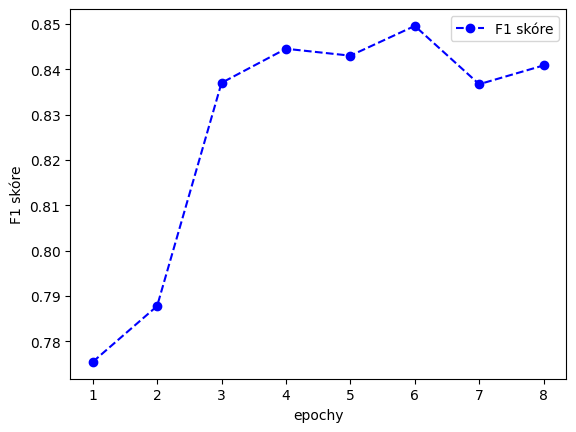

In [3]:
eval = [
0.775424,
0.787751,
0.837014,
0.844538,
0.843011,
0.849576,
0.836713,
0.840860]

import numpy as np
import matplotlib.pyplot as plt

#label x as 'epochy' and y as 'F1 skóre' 
plt.plot(np.arange(1, len(eval)+1), eval, marker='o', label='F1 skóre', color='blue', linestyle='dashed')
plt.legend()
plt.xlabel('Epochy')
plt.ylabel('F1 skóre')